In [24]:
from dotenv import load_dotenv
import os
import json
import textwrap

from langchain_community.graphs import Neo4jGraph
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain.docstore.document import Document
from langchain.chains import GraphCypherQAChain
from langchain_community.llms import Ollama


# Warning control
import warnings
warnings.filterwarnings("ignore")

In [25]:
load_dotenv('.env', override=True)
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
OPENAI_ENDPOINT = 'https://api.openai.com/v1/embeddings'

VECTOR_INDEX_NAME = 'form_10k_chunks'
VECTOR_NODE_LABEL = 'Chunk'
VECTOR_SOURCE_PROPERTY = 'text'
VECTOR_EMBEDDING_PROPERTY = 'textEmbedding'

In [26]:
graph = Neo4jGraph(
    url="bolt://localhost:7688",
    username="neo4j",
    password="your_password"  
)

In [27]:
llm = Ollama(
    model="llama3",  
    temperature=0,
)
llm_transformer = LLMGraphTransformer(llm=llm)

In [28]:
docs = [
    Document(page_content='''
The 20th century witnessed the rise of some of the most influential scientists in history, with Albert Einstein and Marie Curie standing out among them. Einstein, best known for his theory of relativity, revolutionized our understanding of space, time, and energy, earning him the Nobel Prize in Physics in 1921 for his explanation of the photoelectric effect. Marie Curie, a pioneer in the study of radioactivity, was the first woman to win a Nobel Prize. She was awarded the Nobel Prize in'''),
    Document(page_content=''' radioactivity, was the first woman to win a Nobel Prize. She was awarded the Nobel Prize in Physics in 1903, shared with her husband Pierre Curie and Henri Becquerel, for their work on radiation. Curie later made history again by winning a second Nobel Prize in Chemistry in 1911 for her discoveries of radium and polonium. Both scientists made monumental contributions that continue to influence the fields of physics and beyond.
''')
]
docs = [
    Document(page_content="The capital of France is Paris."),
    Document(page_content="Python is a popular programming language."),
]

In [29]:
text = """
Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
She was, in 1906, the first woman to become a professor at the University of Paris.
"""
docs = [Document(page_content=text)]

In [30]:
graph_documents = llm_transformer.convert_to_graph_documents(docs)
print(f"Derived Nodes:\n{graph_documents[0].nodes}\n")
print(f"Derived Edges:\n{graph_documents[0].relationships}")

Derived Nodes:
[Node(id='Pierre Curie', type='Person', properties={}), Node(id='Nobel Prize', type='Award', properties={}), Node(id='University of Paris', type='Organization', properties={}), Node(id='Marie Curie', type='Person', properties={})]

Derived Edges:
[Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='University of Paris', type='Organization', properties={}), type='WORKS_IN', properties={}), Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='Nobel Prize', type='Award', properties={}), type='HAS_AWARD', properties={}), Relationship(source=Node(id='Pierre Curie', type='Person', properties={}), target=Node(id='Marie Curie', type='Person', properties={}), type='CO_WINNER_OF', properties={}), Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='Pierre Curie', type='Person', properties={}), type='WAS_MARRIED_TO', properties={})]


In [31]:
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization"],
    allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
)
graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    docs
)
print(f"Nodes:{graph_documents_filtered[0].nodes}")
print(f"Relationships:{graph_documents_filtered[0].relationships}")

Nodes:[Node(id='Pierre Curie', type='Person', properties={}), Node(id='University of Paris', type='Organization', properties={}), Node(id='Marie Curie', type='Person', properties={}), Node(id='France', type='Country', properties={}), Node(id='Poland', type='Country', properties={})]
Relationships:[Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='Poland', type='Country', properties={}), type='NATIONALITY', properties={}), Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='France', type='Country', properties={}), type='NATIONALITY', properties={}), Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='University of Paris', type='Organization', properties={}), type='WORKED_AT', properties={}), Relationship(source=Node(id='Pierre Curie', type='Person', properties={}), target=Node(id='Marie Curie', type='Person', properties={}), type='SPOUSE', properties={})]


In [33]:
graph.add_graph_documents(graph_documents_filtered)

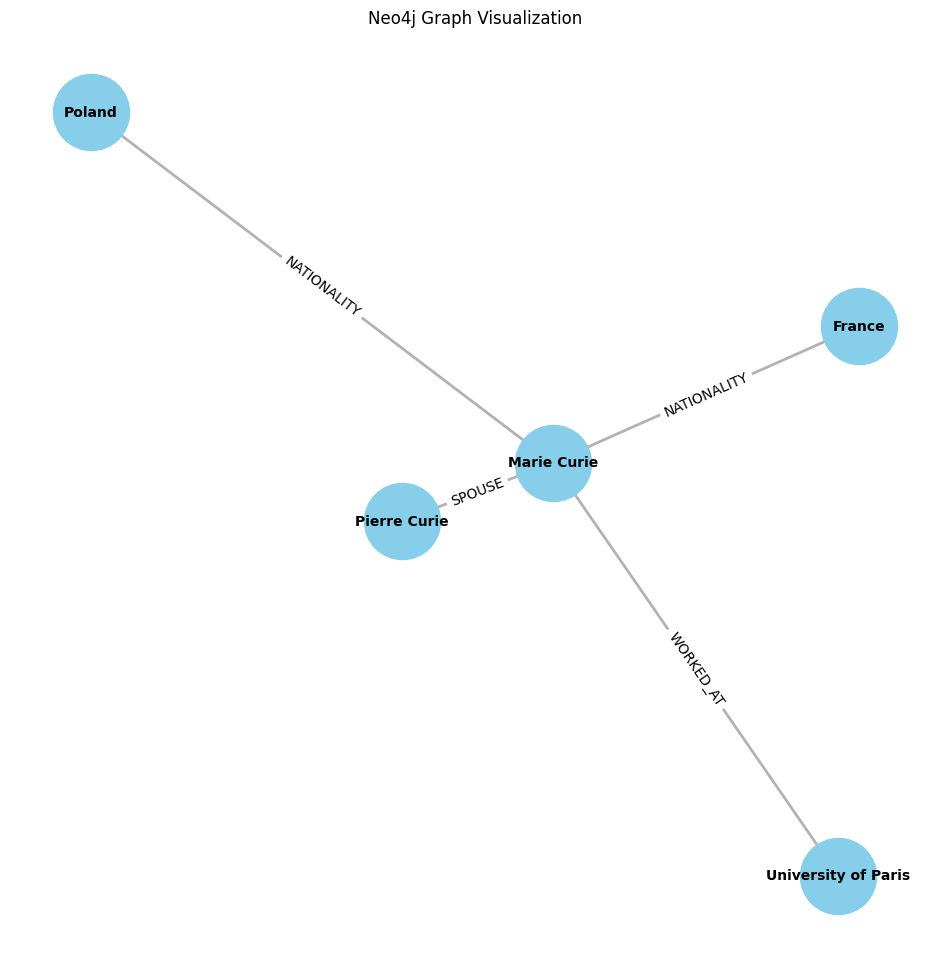

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming the structure of nodes and relationships is different and node is an object
nodes = graph_documents_filtered[0].nodes
edges = graph_documents_filtered[0].relationships

# Create a NetworkX graph (Directed graph)
G = nx.DiGraph()

# Add nodes to the NetworkX graph
for node in nodes:
    # Use node.id as the unique identifier for the node
    G.add_node(node.id, type=node.type)

# Add edges (relationships) to the graph
for relationship in edges:
    # Use relationship.source.id and relationship.target.id as node identifiers
    G.add_edge(relationship.source.id, relationship.target.id, label=relationship.type)

# Visualize the graph using Matplotlib
pos = nx.spring_layout(G)  # Layout for node positioning
plt.figure(figsize=(12, 12))

# Draw the nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="skyblue")
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, alpha=0.6, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Draw edge labels (relationship types)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title("Neo4j Graph Visualization")
plt.axis("off")
plt.show()


In [32]:
# Query the graph
results = graph.query("""
MATCH (relativity:Concept {id: "Theory Of Relativity"}) <-[:KNOWN_FOR]- (scientist)
RETURN scientist
""")

print(results[0])


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: KNOWN_FOR)} {position: line: 2, column: 61, offset: 61} for query: '\nMATCH (relativity:Concept {id: "Theory Of Relativity"}) <-[:KNOWN_FOR]- (scientist)\nRETURN scientist\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available whe

IndexError: list index out of range

In [ ]:
# Create the Graph Cypher QA chain
graph_qa_chain = GraphCypherQAChain.from_llm(
    llm=ChatOpenAI(api_key=OPENAI_API_KEY, temperature=0), graph=graph, verbose=True
)
# Invoke the chain with the input provided
result = graph_qa_chain.invoke({"query": "Who discovered the element Radium?"})
print(result)
# Print the result text
print(f"Final answer: {result['result']}")